In [4]:
from pyBBarolo import version
print (version)

1.3.3dev


In [5]:
fitsname = f"/home/user/THESIS/models/model4/model4.fits"
ringfile = f"/home/user/THESIS/models/model4/model4_params.txt"
BBmain= "BBarolo"

In [ ]:
from pyBBarolo.bayesian import BayesianBBarolo
from pyBBarolo import Param, Rings, FitMod3D, reshapePointer
from pyBBarolo.utils import SimulatedGalaxyCube, emptyfits
from dynesty import plotting as dyplot
from astropy.table import Table 
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
import os, subprocess
from astropy.io import fits
import corner
from ipywidgets import interact, FloatSlider, IntSlider
from GAstro.plot import ploth2
from astropy.io import fits
from pyBBarolo.BB_interface import libBB
import ctypes
import imageio

def chview_gif(data, data2=None, show_residuals=True, output_gif="channel_animation.gif", fps=5, figtitle=None):
    frames = []
    frames_filenames = []
    rms = np.nanstd(data[0, :, :])
    Hres = (data - data2) / rms
    for channel in range(data.shape[0]):  # Iterate over all channels
        if data2 is None:
            fig, ax = plt.subplots(1, 1, figsize=(4, 4))
            axl = [ax, None]
        elif show_residuals:
            fig, axl = plt.subplots(1, 3, figsize=(12, 4))
        else:
            fig, axl = plt.subplots(1, 2, figsize=(8, 4))

        # First data
        ax = axl[0]
        rms = np.nanstd(data[0, :, :])
        if rms == 0: rms = 0.001
        dmax = np.nanmax(data)
        levels = [-3 * rms,] + list(np.linspace(2 * rms, dmax, 6))
        vmin = 0.1 * np.min(data)
        vmax = 0.99 * np.max(data)

        _ = ploth2(ax=ax, H=data[channel, :, :], edges=(np.arange(0, data.shape[1]), np.arange(0, data.shape[2])),
                   cmap="plasma", gamma=0.5, vmin=vmin, vmax=vmax, vminmax_option="absolute",
                   levels=levels, levels_color="lime")

        ax.set_title(f"Data: Channel {channel}")
        
        if data2 is not None:
            ax = axl[1]
            _ = ploth2(ax=ax, H=data2[channel, :, :], edges=(np.arange(0, data2.shape[1]), np.arange(0, data2.shape[2])),
                       cmap="plasma", gamma=0.5, vmin=vmin, vmax=vmax, vminmax_option="absolute",
                       levels=levels, levels_color="lime")
            ax.set_title(f"Model:  Channel {channel}")
            
            if show_residuals:
                ax = axl[2]
                _ = ploth2(ax=ax, H=Hres[channel, :, :], edges=(np.arange(0, data2.shape[1]), np.arange(0, data2.shape[2])),
                           cmap="seismic", gamma=1, vmin=-10, vmax=10, vminmax_option="absolute", colorbar=True)
                ax.set_title(f"Residuals: Channel {channel}, Sum={np.nansum(Hres[channel,:,:]):4g}")

            if figtitle is not None:
                fig.suptitle(figtitle)

        fig.tight_layout()

        # Save frame
        frame_filename = f"frame_{channel}.png"
        plt.savefig(frame_filename)
        plt.close(fig)

        # Append frame to list
        frames_filenames.append(frame_filename)
        frames.append(imageio.imread(frame_filename))
 
    # Convert image list to animated GIF
    # Save frames as a GIF
    imageio.mimsave(output_gif, frames, fps=fps)
    print(f"GIF saved as {output_gif}")

    # Remove all PNG frames after creating the GIF
    for filename in frames_filenames:
        os.remove(filename)

def chview(data,data2=None,show_residuals=True):

        
    def plot_channel(channel):

        if data2 is None: 
            fig,ax=plt.subplots(1,1,figsize=(4, 4))
            axl=[ax,None]
        elif show_residuals: 
            fig,axl=plt.subplots(1,3,figsize=(12, 4))
        else:
            fig,axl=plt.subplots(1,2,figsize=(8, 4))
        
        #First data
        ax=axl[0]
        rms=np.nanstd(data[0,:,:])
        print(rms)
        if rms==0: rms=0.001
        dmax=np.nanmax(data)
        levels=[-3*rms,]+list(np.linspace(2*rms,dmax,6))
        vmin=0.1*np.min(data)
        vmax=0.99*np.max(data)

        print(channel)
        
        _=ploth2(ax=ax,H=data[channel,:,:],edges=(np.arange(0,data.shape[1]),np.arange(0,data.shape[2])),
            cmap="plasma",gamma=0.5,vmin=vmin,vmax=vmax, vminmax_option="absolute",
            levels=levels,levels_color="lime")
        plt.sca(ax)

        if data2 is not None:
            ax=axl[1]
            _=ploth2(ax=ax,H=data2[channel,:,:],edges=(np.arange(0,data2.shape[1]),np.arange(0,data2.shape[2])),
            cmap="plasma",gamma=0.5,vmin=vmin,vmax=vmax, vminmax_option="absolute",
            levels=levels,levels_color="lime")
            plt.sca(ax)

            if show_residuals:
                Hres=(data-data2)/rms
                ax=axl[2]
                _=ploth2(ax=ax,H=Hres[channel,:,:],edges=(np.arange(0,data2.shape[1]),np.arange(0,data2.shape[2])),
                cmap="seismic",gamma=1,vmin=-10,vmax=10, vminmax_option="absolute",colorbar=True)
                plt.sca(ax)                
                
        fig.tight_layout()
        
    interact(plot_channel, channel=IntSlider(value=0, min=0, max=data.shape[0]-1, step=1))
    plt.show()

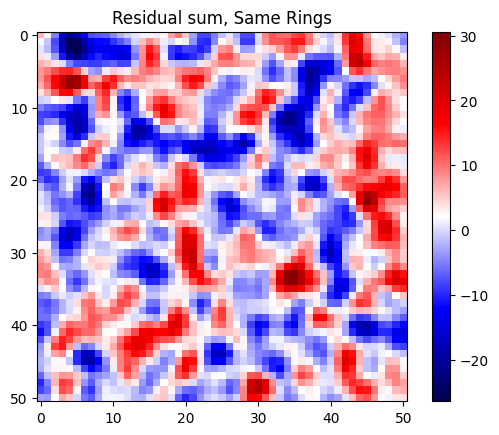

[ 30  90 150 210]


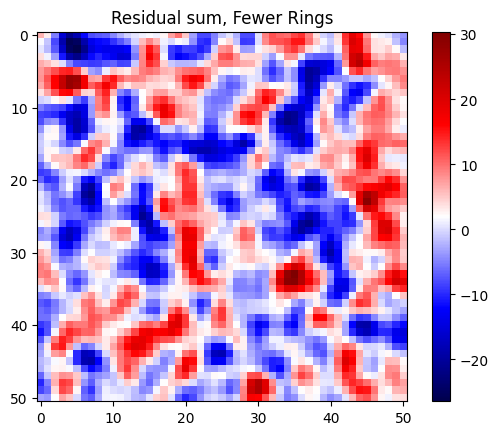

In [7]:
def create_cube_serial(input_dfu,xpos, ypos, rad,vsys,vdisp,inc,pa,\
                dens,z0,vrot,noise_mult=0.001,BBmain="/home/user/Bbarolo/BBarolo",outfolder="BBmod_tmp"):
    #IMPUT FILES
    BBmain= BBmain
    data=input_dfu[0].data
    
    hd=input_dfu[0].header
    axisDim=[hd["NAXIS1"],hd["NAXIS2"],hd["NAXIS3"]]
    cdelts=[hd["CDELT1"],hd["CDELT2"],hd["CDELT3"]]
    crpixs=[hd["CRPIX1"],hd["CRPIX2"],hd["CRPIX3"]]
    crvals=[hd["CRVAL1"],hd["CRVAL2"],hd["CRVAL3"]]
    ctypes=[hd["CTYPE1"],hd["CTYPE2"]]
    cunits=[hd["CUNIT1"],hd["CUNIT2"],hd["CUNIT3"]]
    beam=[hd["BMAJ"],hd["BMIN"],hd["BPA"]]
    obj="tmp"
    bunit=hd["BUNIT"]
    sm=SimulatedGalaxyCube(axisDim=axisDim,cdelts=cdelts,crpixs=crpixs,crvals=crvals,ctypes=None,cunits=None,\
                  data=None,beam=beam,obj=obj,bunit=bunit,dtype=np.float32)

    sm.define_galaxy(xpos=xpos, ypos=ypos, radii=rad,vsys=vsys,vdisp=vdisp,inc=inc,pa=pa,\
                    dens=dens,z0=z0,vrot=vrot,warpinc=False,warppa=False)
    sm.run(exe=BBmain,stdout='null',smooth=True,noise=noise_mult*np.std(data[0,:,:]),outfolder=outfolder) #HERE IS WHERE THE NOISE IS ADDED

    if noise_mult>0: dfu_output=fits.open(f"{outfolder}/{obj}mod_noise.fits")
    else: dfu_output=fits.open(f"{outfolder}/{obj}mod_nonorm.fits")
    
    return dfu_output

#fits was here

dfu=fits.open(fitsname)
data=dfu[0].data


tabinp=np.loadtxt(ringfile,)
rad = tabinp[:,0] 
xpos= tabinp[:,8] 
ypos= tabinp[:,9]
vsys= tabinp[:,10]
vrad= tabinp[:,2]
z0=  tabinp[:,6]
inc= tabinp[:,4]
pa= tabinp[:,5]
vrot= tabinp[:,1]
vdisp= tabinp[:,3]
dens=tabinp[:,7]


dfm=create_cube_serial(dfu,xpos=xpos, ypos=ypos, rad=rad,vsys=vsys,vdisp=vdisp,inc=inc,pa=pa,\
                    dens=dens,z0=z0,vrot=vrot,noise_mult=0)

#chview_gif(data,dfm[0].data,show_residuals=True, output_gif="same_rings.gif" , figtitle="Same Rings")

plt.imshow( np.sum((data-dfm[0].data)/np.std(data[0]),axis=0).T,cmap="seismic")
plt.colorbar()
plt.title("Residual sum, Same Rings")
plt.show()

rad=np.arange(30,240,60)
xpos=np.ones_like(rad)*25.5
ypos=np.ones_like(rad)*25.5
vsys=np.ones_like(rad)*0
vdisp=np.ones_like(rad)*10
inc=np.ones_like(rad)*70
pa=np.ones_like(rad)*0
dens=np.ones_like(rad)*10
z0=np.ones_like(rad)*30
vrot=np.ones_like(rad)*100
print(rad)

dfm=create_cube_serial(dfu,xpos=xpos, ypos=ypos, rad=rad,vsys=vsys,vdisp=vdisp,inc=inc,pa=pa,\
                    dens=dens,z0=z0,vrot=vrot,noise_mult=0)

#chview_gif(data,dfm[0].data,show_residuals=True, output_gif="fewer_rings.gif" , figtitle="Fewer Rings")

plt.imshow( np.sum((data-dfm[0].data)/np.std(data[0]),axis=0).T,cmap="seismic" )
plt.colorbar()
plt.title("Residual sum, Fewer Rings")
plt.show()

HEADER WARNING: TELESCOP-INSTRUME keywords not found.

Opening file /home/user/THESIS/models/model4/model4.fits
Reading 51 x 51 x 64 pixels FITS file (0.6 MB)... Done. 



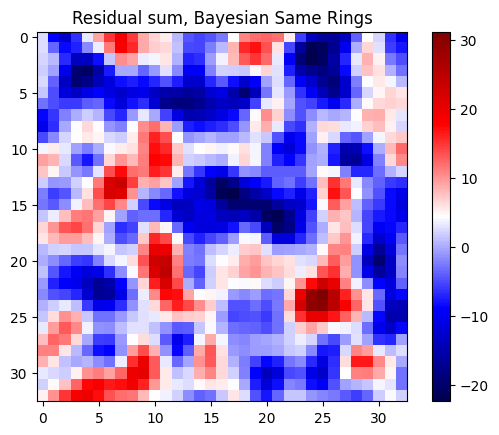

HEADER WARNING: TELESCOP-INSTRUME keywords not found.

Opening file /home/user/THESIS/models/model4/model4.fits
Reading 51 x 51 x 64 pixels FITS file (0.6 MB)... Done. 



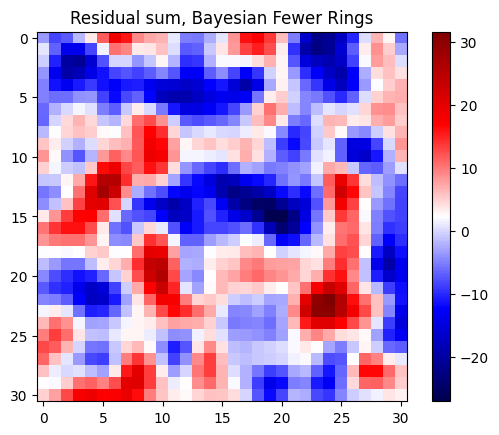

In [8]:
# fits was here

dfu=fits.open(fitsname)
data=dfu[0].data
rms=np.std(data[0,:,:])

tabinp=np.loadtxt(ringfile,)[1:]
rad = tabinp[:,0] 
xpos= tabinp[:,8] 
ypos= tabinp[:,9]
vsys= tabinp[:,10]
vrad= tabinp[:,2]
z0=  tabinp[:,6]
inc= tabinp[:,4]
phi= tabinp[:,5]
vrot= tabinp[:,1]
vdisp= tabinp[:,3]
dens= tabinp[:,7]

#Same rings
# Creating an object for bayesian barolo
f3d = BayesianBBarolo(fitsname)


f3d.init(radii=rad,xpos=xpos,ypos=ypos,vsys=vsys,\
        vrot=vrot,vdisp=vdisp,vrad=vrad,z0=z0,inc=inc,phi=phi,dens=dens)
f3d.set_options(mask="NONE",linear=0,outfolder=f"output/bla",plotmask=True)
f3d._setup(freepar=['inc_single'],useBBres=False)
theta=np.array((inc[0],))
rings = f3d._update_rings(f3d._inri,theta)
mod, bhi, blo, galmod = f3d._calculate_model(rings)
datar=data[:,blo[0]:bhi[0],blo[0]:bhi[0]]
norm=np.sum(datar)/np.sum(mod)


plt.imshow( np.sum((datar-mod*norm)/np.std(datar[0]),axis=0).T,cmap="seismic")
plt.colorbar()
plt.title("Residual sum, Bayesian Same Rings")
plt.show()

#chview_gif(datar,mod*norm, output_gif="Bayesian_same_rings.gif" , figtitle="Bayesian Same Rings")

#Fewer rings

rad=np.arange(30,240,60)
xpos=np.ones_like(rad)*25.5
ypos=np.ones_like(rad)*25.5
vsys=np.ones_like(rad)*0
vdisp=np.ones_like(rad)*10
inc=np.ones_like(rad)*70
phi=np.ones_like(rad)*0
dens=np.ones_like(rad)*10
z0=np.ones_like(rad)*30
vrot=np.ones_like(rad)*100
vrad=np.ones_like(rad)*0

# Creating an object for bayesian barolo
f3d = BayesianBBarolo(fitsname)


f3d.init(radii=rad,xpos=xpos,ypos=ypos,vsys=vsys,\
        vrot=vrot,vdisp=vdisp,vrad=vrad,z0=z0,inc=inc,phi=phi,dens=dens)
f3d.set_options(mask="NONE",linear=0,outfolder=f"output/bla",plotmask=True)
f3d._setup(freepar=['inc_single'],useBBres=False)
theta=np.array((inc[0],))
rings = f3d._update_rings(f3d._inri,theta)
mod, bhi, blo, galmod = f3d._calculate_model(rings)
datar=data[:,blo[0]:bhi[0],blo[0]:bhi[0]]
norm=np.sum(datar)/np.sum(mod)

plt.imshow( np.sum((datar-mod*norm)/np.std(datar[0]),axis=0).T,cmap="seismic")
plt.colorbar()
plt.title("Residual sum, Bayesian Fewer Rings")
plt.show()

#chview_gif(datar,mod*norm, output_gif="Bayesian_fewer_rings.gif" , figtitle="Bayesian Fewer Rings")

HEADER WARNING: TELESCOP-INSTRUME keywords not found.

Opening file /home/user/THESIS/models/model4/model4.fits
Reading 51 x 51 x 64 pixels FITS file (0.6 MB)... Done. 


 
 True Same rings ll -190467.14


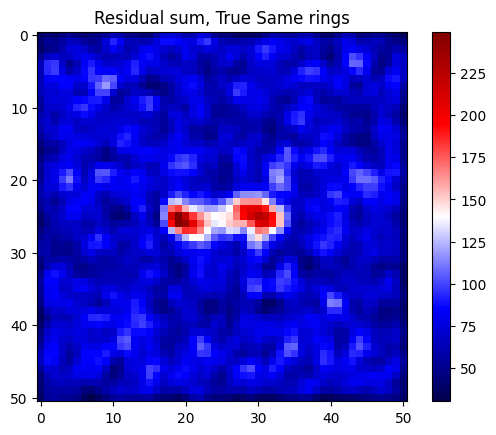

HEADER WARNING: TELESCOP-INSTRUME keywords not found.

Opening file /home/user/THESIS/models/model4/model4.fits
Reading 51 x 51 x 64 pixels FITS file (0.6 MB)... Done. 


 
 True ll -194382.8


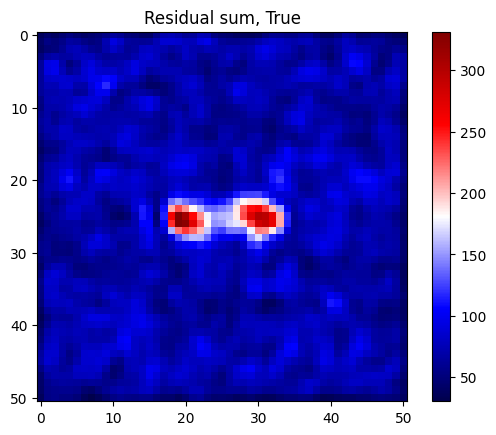

HEADER WARNING: TELESCOP-INSTRUME keywords not found.

Opening file /home/user/THESIS/models/model4/model4.fits
Reading 51 x 51 x 64 pixels FITS file (0.6 MB)... Done. 


 
 Best fit ll -192135.02


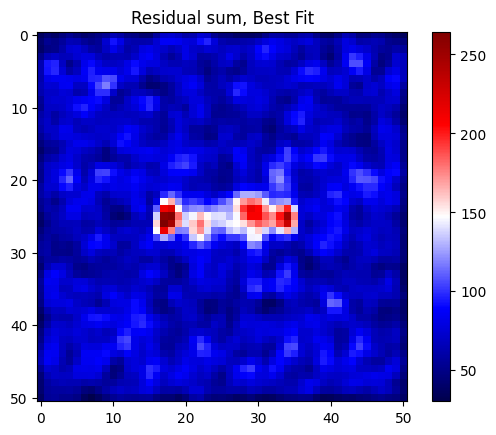

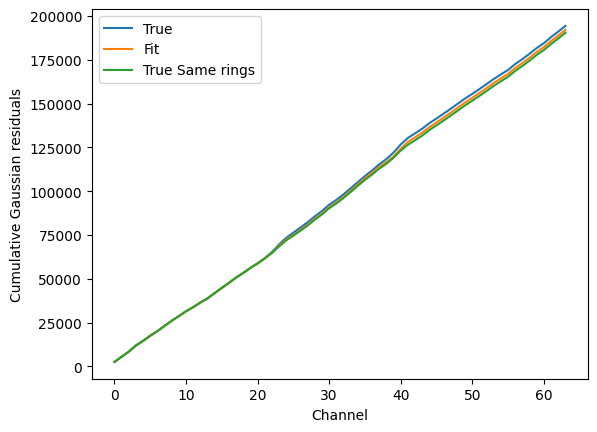

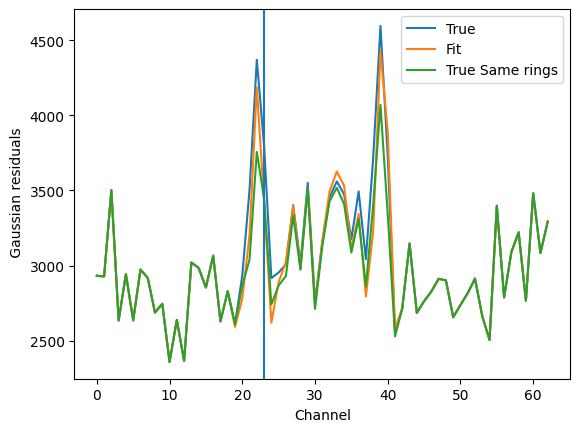

In [9]:
def my_norm(model,data):
    nrm = np.nansum(data)/np.nansum(model)
    return nrm*model

def res_Gaussian(data,model,noise,mask,multiplier=1):
    """
    Gaussian residuals with noise
    """

    data *= mask
    model = my_norm(model,data)
    res = np.nansum((data-model)**2)

    return multiplier*res/(noise*noise)


def res_Gaussian_true(data,model,noise,mask,multiplier=1,fsysnoise=0):
    """
    Gaussian residuals with noise
    """

    data *= mask
    model = my_norm(model,data)
    totnoise2=noise*noise*(1+fsysnoise)
    res = (data-model)**2/(totnoise2)
    res_sys_noise = np.log(2*np.pi*totnoise2)
    
    return multiplier*0.5*np.sum(res+res_sys_noise)





##HERE WE MODIFY THE MAIN Byesian Barolo  implementation
class BayesianBBaroloMod(BayesianBBarolo):

    def __init__(self,fitsname,**kwargs):
        """ Initialize the BayesianBBarolo class.
    
        Parameters
        ----------
        fitsname : str
            The name of the fits file with the datacube to fit.
        **kwargs : dict
            Any other parameter to be passed to the BBarolo's library.
        """

        super(BayesianBBaroloMod,self).__init__(fitsname,**kwargs)
        self.noise=None
        self.Npix=None

    def _calculate_model(self,rings):
            """ This function calculates a unnormalized model given a set of rings.
            
                Parameters
                ----------
                rings : Rings
                    A Rings object with the parameters of the model.
    
                Returns
                -------
                mod : 3D array
                    A 3D array with the model.
                bhi, blo : 1D arrays
                    The boundaries of the model in the input cube.
                galmod : pointer 
                    A pointer to the Galmod object. Need to be freed after use.
            """
            # Model is built in a smaller array (blo,bhi) that only contains the galaxy 
            # within the last ring. This is to calculate the residuals faster.
            _, ys, xs = self.data.shape
            bhi, blo = (ctypes.c_int * 2)(xs,ys), (ctypes.c_int * 2)(0)
            #libBB.Galfit_getModelSize(self._galfit,rings._rings,bhi,blo)
            galmod = libBB.Galfit_getModel(self._galfit,rings._rings,bhi,blo)
            bhi, blo = np.array(bhi), np.array(blo)
            # Reshaping the model to the correct 3D shape
            mod_shape = (self.inp.dim[-1], bhi[1]-blo[1],bhi[0]-blo[0])
            mod = reshapePointer(libBB.Galmod_array(galmod),self.data.shape)

    
            return mod, bhi, blo, galmod
    
    def _log_likelihood(self,theta):
        """ Likelihood function for the fit """
        
        rings = self._update_rings(self._inri,theta)

        # Calculate likelihood 
        if self.noise is None: self.noise=np.nanstd(self.data[0,:,:])
        if self.Npix is None:  self.Npix=np.prod(self.data.shape)

        if self.useBBres:
            # Calculating residuals through BBarolo directly
            res = libBB.Galfit_calcresiduals(self._galfit,rings._rings)
        else: 
            # Calculating residuals manually            

            # Recompute the density profile along the current rings and update the rings
            if self.useNorm and self.update_prof:
                self._update_profile(rings)

            # Calculate the model and the boundaries
            mod, bhi, blo, galmod = self._calculate_model(rings)
            
            # Calculate the residuals
            mask = self.mask[:,blo[1]:bhi[1],blo[0]:bhi[0]]
            data = self.data[:,blo[1]:bhi[1],blo[0]:bhi[0]]
            res  = self._calculate_residuals(mod,data,mask)

            libBB.Galmod_delete(galmod)
            
        return -res

    #Uncomment
    #Gaussian 
    def _calculate_residuals(self,model,data,mask=None):
        
        #Option A: Standard absolute residuals: no noise, residual muplitied by 1000 as done before
        #res=res_abs(model=model, data=data, noise=1, mask=mask, multiplier=1000)

        #Option B Standard absolute residuals: cube noise, residual muplitied by 1000 as done before
        #res=res_abs(model=model, data=data, noise=self.noise, mask=mask, multiplier=1000)

        #Option C Standard Gaussian residuals: cube noise,
        res=res_Gaussian(model=model, data=data, noise=self.noise, mask=mask, multiplier=1)

        #Option D Gaussian residuals: no noise
        #res=res_Gaussian(model=model, data=data, noise=1, mask=mask, multiplier=1)

        #Option E Gaussian residuals: no noise, multiplied by 1000
        #res=res_Gaussian(model=model, data=data, noise=1, mask=mask, multiplier=1000)


        #res=res_Gaussian_true(model=model, data=data, noise=self.noise, mask=mask, multiplier=1,fsysnoise=0.)
        #print(res)

        return res
    

#fits was here

dfu=fits.open(fitsname)
data=dfu[0].data
rms=np.std(data[0,:,:])

tabinp=np.loadtxt(ringfile,)[1:]
rad = tabinp[:,0] 
xpos= tabinp[:,8] 
ypos= tabinp[:,9]
vsys= tabinp[:,10]
vrad= tabinp[:,2]
z0=  tabinp[:,6]
inc= tabinp[:,4]
phi= tabinp[:,5]
vrot= tabinp[:,1]
vdisp= tabinp[:,3]
dens= tabinp[:,7]

# Same rings
f3d = BayesianBBaroloMod(fitsname)


f3d.init(radii=rad,xpos=xpos,ypos=ypos,vsys=vsys,\
        vrot=vrot,vdisp=vdisp,vrad=vrad,z0=z0,inc=inc,phi=phi,dens=dens)
f3d.set_options(mask="NONE",linear=0,outfolder=f"output/bla",plotmask=True)
f3d._setup(freepar=['inc_single'],useBBres=False)
theta=np.array((70,))
rings = f3d._update_rings(f3d._inri,theta)
mod, bhi, blo, galmod = f3d._calculate_model(rings)
datar=data[:,blo[0]:bhi[0],blo[0]:bhi[0]]


print("\n \n True Same rings ll",f3d._log_likelihood(theta))

norm=np.sum(datar)/np.sum(mod)
plt.imshow( np.sum((datar-mod*norm)**2/np.std(datar[0])**2,axis=0).T,cmap="seismic")
plt.colorbar()
plt.title("Residual sum, True Same rings")
plt.show()

#chview_gif(datar,mod*norm, output_gif="true_samerings.gif" , figtitle="True Same rings")

bychannelsum=np.sum((datar-mod*norm)**2/np.std(datar[0])**2,axis=(1,2))
cumsumres_true_samerings=np.cumsum(bychannelsum)


#Fewer rings

rad=np.arange(30,240,60)
xpos=np.ones_like(rad)*25.5
ypos=np.ones_like(rad)*25.5
vsys=np.ones_like(rad)*0
vdisp=np.ones_like(rad)*10
inc=np.ones_like(rad)*70
phi=np.ones_like(rad)*0
dens=np.ones_like(rad)*10
z0=np.ones_like(rad)*30
vrot=np.ones_like(rad)*100
vrad=np.ones_like(rad)*0

# Creating an object for bayesian barolo
f3d = BayesianBBaroloMod(fitsname)


f3d.init(radii=rad,xpos=xpos,ypos=ypos,vsys=vsys,\
        vrot=vrot,vdisp=vdisp,vrad=vrad,z0=z0,inc=inc,phi=phi,dens=dens)
f3d.set_options(mask="NONE",linear=0,outfolder=f"output/bla",plotmask=True)
f3d._setup(freepar=['inc_single'],useBBres=False)
theta=np.array((70,))
rings = f3d._update_rings(f3d._inri,theta)
mod, bhi, blo, galmod = f3d._calculate_model(rings)
datar=data[:,blo[0]:bhi[0],blo[0]:bhi[0]]

print("\n \n True ll",f3d._log_likelihood(theta))

norm=np.sum(datar)/np.sum(mod)
plt.imshow( np.sum((datar-mod*norm)**2/np.std(datar[0])**2,axis=0).T,cmap="seismic")
plt.colorbar()
plt.title("Residual sum, True")
plt.show()

#chview_gif(datar,mod*norm, output_gif="true.gif" , figtitle="True")

bychannelsum=np.sum((datar-mod*norm)**2/np.std(datar[0])**2,axis=(1,2))
cumsumres_true=np.cumsum(bychannelsum)

## Fit results
rad=np.arange(30,240,60)
ones=np.ones_like(rad)
xpos = 25.5*ones
ypos = 25.5*ones
vsys=np.ones_like(rad)*0
vrad=np.ones_like(rad)*0
vdisp=np.array([6.5,9.3,9.4,7.8])
inc=ones*70.702
phi=ones*0.092
dens=np.array([5.2,6.2,4.1,9.7])
z0=ones*30.
vrot=np.array([96.6,99.16,101.7,98.1])

# Creating an object for bayesian barolo
f3d = BayesianBBaroloMod(fitsname)

f3d.init(radii=rad,xpos=xpos,ypos=ypos,vsys=vsys,\
        vrot=vrot,vdisp=vdisp,vrad=vrad,z0=z0,inc=inc,phi=phi,dens=dens)
f3d.set_options(mask="NONE",linear=0,outfolder=f"output/bla",plotmask=True)
freepar= ['vrot','vdisp','dens','inc_single','phi_single']
f3d._setup(freepar=freepar,useBBres=False)
theta=np.array(list(vrot)+list(vdisp)+list(dens)+[inc[0],phi[0]])
rings = f3d._update_rings(f3d._inri,theta)
mod, bhi, blo, galmod = f3d._calculate_model(rings)
datar=data[:,blo[0]:bhi[0],blo[0]:bhi[0]]

print("\n \n Best fit ll",f3d._log_likelihood(theta))


norm=np.sum(datar)/np.sum(mod)
plt.imshow( np.sum((datar-mod*norm)**2/np.std(datar[0])**2,axis=0).T,cmap="seismic")
plt.colorbar()
plt.title("Residual sum, Best Fit")
plt.show()

bychannelsum=np.sum((datar-mod*norm)**2/np.std(datar[0])**2,axis=(1,2))
cumsumres_fit=np.cumsum(bychannelsum)



plt.plot(cumsumres_true,label="True")
plt.plot(cumsumres_fit,label="Fit")
plt.plot(cumsumres_true_samerings,label="True Same rings")
plt.xlabel("Channel")
plt.ylabel("Cumulative Gaussian residuals")
plt.legend()
#plt.yscale("log")
plt.show()


plt.plot(cumsumres_true[1:]-cumsumres_true[:-1],label="True")
plt.plot(cumsumres_fit[1:]-cumsumres_fit[:-1],label="Fit")
plt.plot(cumsumres_true_samerings[1:]-cumsumres_true_samerings[:-1],label="True Same rings")
plt.xlabel("Channel")
plt.ylabel(" Gaussian residuals")
plt.legend()
#plt.yscale("log")
plt.axvline(23)
plt.show()

#chview_gif(datar,mod*norm, output_gif="Best_fit.gif" , figtitle="Best Fit")
